# COS711 A2
> Dino Gironi (u21630276)

### Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

pd.options.display.width = 200
pd.options.display.max_columns = 20

# Import Almond.csv
almondOrig: pd.DataFrame = pd.read_csv('Almond.csv')
almondOrig.columns = ['idx', 'len', 'wid', 'thk', 'area', 'perim', 'round', 'solid', 'compact', 'aspect', 'eccent', 'extent', 'convex', 'type']

#=============== PREPROCESSING ===============#

# Remove useless/redundant cols
# almond = almond.drop(['idx', 'round', 'aspect', 'eccent'], axis=1)
almond = almondOrig.drop(['idx'], axis=1)

# Convert target type to one-hot encoding & drop
typeOneHot = pd.get_dummies(almond['type'])
typeOneHot.columns = ['mamra', 'regular', 'sanora']
almond = almond.drop('type', axis=1)

# Coerce to numeric
almond = almond.apply(pd.to_numeric, errors='coerce')

print("-"*50 + " almond " + "-"*50)
print(almond)

# Isolate len, wid, thk cols & replace missing values with -1
dims: pd.DataFrame = almond[['len', 'wid', 'thk']]
dims = dims.fillna(-1)

# Create one-hot encoding for missing values
dimsOneHot = dims.copy()
dimsOneHot[dimsOneHot != -1] = 0
dimsOneHot[dimsOneHot == -1] = 1
dimsOneHot.columns = ['len1H', 'wid1H', 'thk1H']

print("-"*50 + " dims " + "-"*50)
print(dims.head(n=20))

print("-"*50 + " dimsOneHot " + "-"*50)
print(dimsOneHot.head(n=20))

# Sort within row + delete first col (empty after sort)
dimsSorted: pd.Series = dims.apply(np.sort, axis=1)
dims = pd.DataFrame(dimsSorted.values.tolist(), index=dimsSorted.index, columns=['null', 'wid', 'len'])
dims = dims[['wid', 'len']]

# Replace len, wid, thk cols in almond with sorted values
almond[['wid', 'len']] = dims
almond.drop('thk', axis=1, inplace=True)

# Insert one-hot encoding for missing values
almond.insert(2, 'thk1H', dimsOneHot['thk1H'])
almond.insert(2, 'wid1H', dimsOneHot['wid1H'])
almond.insert(2, 'len1H', dimsOneHot['len1H'])
almond[['len1H', 'wid1H', 'thk1H']] = dimsOneHot

# Recompute round, aspect, eccent with new len, wid
almond['round'] = 4 * almond['area'] / (np.pi * almond['len']**2)
almond['aspect'] = almond['len'] / almond['wid']
almond['eccent'] = np.sqrt(1 - (almond['wid'] / almond['len'])**2)

# Split to X, Y
# Y = almond['type']
X = almond.astype(float)
Y = typeOneHot.astype(int)

# Print fully preprocessed dataset
print("-"*50 + " Inputs (X) - fully preprocessed " + "-"*50)
print(X)
print("-"*50 + " Targets (Y) - fully preprocessed " + "-"*50)
print(Y)

-------------------------------------------------- almond --------------------------------------------------
             len         wid         thk     area       perim     round     solid   compact    aspect   eccent    extent   convex
0            NaN  227.940628  127.759132  22619.0  643.813269       NaN  0.973384  1.458265       NaN      NaN  0.681193  23237.5
1            NaN  234.188126  128.199509  23038.0  680.984841       NaN  0.957304  1.601844       NaN      NaN  0.656353  24065.5
2            NaN  229.418610  125.796547  22386.5  646.943212       NaN  0.967270  1.487772       NaN      NaN  0.683620  23144.0
3            NaN  232.763153  125.918808  22578.5  661.227483       NaN  0.965512  1.540979       NaN      NaN  0.685360  23385.0
4            NaN  230.150742  107.253448  19068.0  624.842706       NaN  0.951450  1.629395       NaN      NaN  0.714800  20041.0
...          ...         ...         ...      ...         ...       ...       ...       ...       ...      ... 

### Attribute distributions

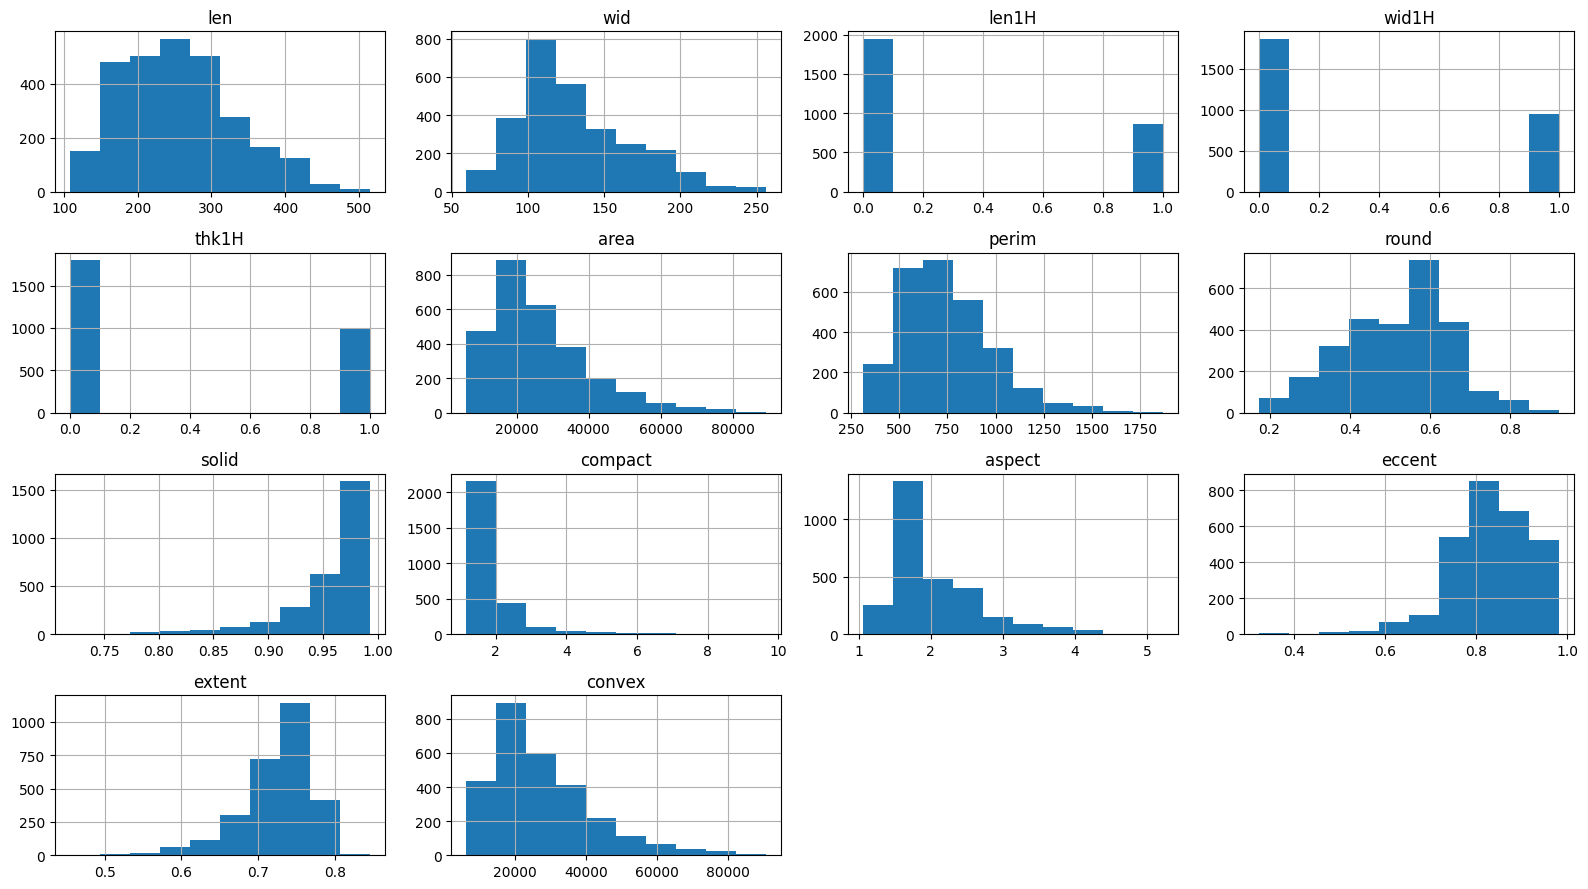

In [2]:
import matplotlib.pyplot as plt
X.hist(figsize=(16, 9))
plt.tight_layout()
plt.title("All attributes")
plt.show()

### Define neural net

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from typing import TypedDict, Callable, Tuple, List, cast

#----- Define NN -----#
class NeuralNet(nn.Module):
    def __init__(self, inDim, outDim, layerSize = 64, squeeze = 32, activation = nn.ReLU, dropout = 0):
        super(NeuralNet, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(inDim,     layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, squeeze),   activation(), nn.Dropout(dropout),
            nn.Linear(squeeze,   layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, layerSize), activation(), nn.Dropout(dropout),
            nn.Linear(layerSize, outDim)
        )
    
    def forward(self, x):
        return self.stack(x)

#----- Wrapper types -----#
Net = TypedDict('Net', { 'model': NeuralNet, 'criterion': nn.Module, 'optimizers': List[optim.Optimizer] })
TrainResults = TypedDict('TrainResults', { 'losses': list, 'accuracies': list })
Runnable = Callable[[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], Tuple[TrainResults, float]]

### Init & Splitting test/training

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from numpy import ndarray

#----- Get compute device -----#
dev = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# dev = "cpu"
print(f"Using device: \033[0;94m{dev}\033[0m")


#----- Rescale & Encode features -----#
scaler = StandardScaler()
datX: ndarray = scaler.fit_transform(X.values)
datY: ndarray = Y.values

Using device: cuda


### Constructor functions

In [17]:
from typing import List, Tuple, Optional

#----- Split test / training -----#
def runTrainTest(func: Runnable) -> Tuple[TrainResults, float]:
    global datX, datY
    trainX, testX, trainY, testY = train_test_split(datX, datY, test_size=0.2, random_state=69)

    # Convert to PyTorch tensors
    trainX = torch.tensor(trainX, dtype=torch.float32).to(dev)
    trainY = torch.tensor(trainY, dtype=torch.float32).to(dev)
    testX = torch.tensor(testX, dtype=torch.float32).to(dev)
    testY = torch.tensor(testY, dtype=torch.float32).to(dev)

    res = func(trainX, trainY, testX, testY)
    del trainX, trainY, testX, testY
    return res


#----- K-Fold -----#
def runKFold(func: Runnable, k: int = 5) -> List[Tuple[TrainResults, float]]:
    global datX, datY
    kfold = KFold(n_splits=k, shuffle=True, random_state=69)

    results = []
    for a, b in kfold.split(datX, datY):
        trainX, trainY = torch.tensor(datX[a], dtype=torch.float32).to(dev), torch.tensor(datY[a], dtype=torch.float32).to(dev)
        testX, testY = torch.tensor(datX[b], dtype=torch.float32).to(dev), torch.tensor(datY[b], dtype=torch.float32).to(dev)
        res = func(trainX, trainY, testX, testY)
        results.append(res)
    return results

def aggrKFold(foldRes: List[Tuple[TrainResults, float]]) -> dict:
    trainLosses = [trainRes["losses"][-1] for trainRes, _ in foldRes]
    trainAccs = [trainRes["accuracies"][-1] for trainRes, _ in foldRes]
    testAccs = [testAcc for _, testAcc in foldRes]
    return {
        "trainLoss": { "mean": np.mean(trainLosses), "std": np.std(trainLosses) },
        "trainAcc":  { "mean": np.mean(trainAccs),   "std": np.std(trainAccs)   },
        "testAcc":   { "mean": np.mean(testAccs),    "std": np.std(testAccs)    }
    }


#----- NN creation function -----#
def createNN(inDim, outDim, loss = nn.MSELoss, opts = [optim.Rprop], act = nn.ReLU, lr: Optional[float] = None) -> Net:
    # Create model instance
    model = NeuralNet(inDim, outDim, activation = act).to(dev)

    # Define loss + optimizers
    criterion = loss()
    optimizers = []
    if lr is not None:
        optimizers = [ opt(model.parameters(), lr=lr) for opt in opts ]
    else:
        optimizers = [ opt(model.parameters()) for opt in opts ]

    return { 'model': model, 'criterion': criterion, 'optimizers': optimizers }


#----- Evaluation function -----#
def metrics(pred: np.ndarray, targ1H: np.ndarray) -> float:
    predLen = pred.shape[0]
    pred1H = np.zeros_like(pred).astype(int) # Convert pred to one-hot
    pred1H[np.arange(predLen), pred] = 1

    accuracy = np.sum(pred1H == targ1H) / (3 * predLen) # Acc for 3 val one-hot
    return accuracy


#----- Testing function -----#
def test(net: Net, x: torch.Tensor, y: torch.Tensor):
    model: NeuralNet = net["model"]

    model.eval()
    outputs = model(x)
    _, pred = torch.max(outputs, 1)
    pred1H = torch.zeros_like(outputs)
    pred1H[np.arange(outputs.shape[0]), pred] = 1

    acc = (pred1H == y).sum().item() / (3 * y.shape[0])
    return acc


#----- Training function -----#
def train(net: Net, x: torch.Tensor, y: torch.Tensor, epochs = 2000, printFreq = 100) -> TrainResults:
    model = net['model']; criterion = net['criterion']; optimizers = net['optimizers']
    model.train()

    losses, accs = [], []
    totCorrect, totSamples = 0, 0
    numOpt = len(optimizers)

    for e in range(epochs):
        #--- Forward pass ---#
        outputs: torch.Tensor = model(x)
        loss: torch.Tensor = criterion(outputs, y)

        _, predicted = torch.max(outputs, 1)
        pred1H = torch.zeros_like(outputs)
        pred1H[np.arange(outputs.shape[0]), predicted] = 1

        totCorrect += (pred1H == y).sum().item() / 3.0
        totSamples += y.shape[0]

        #--- Backward pass and optimization ---#
        # Clear grads for all optimizers
        for opt in optimizers:
            opt.zero_grad()

        loss.backward() # Compute new grads

        # Average grads
        for param in model.parameters():
            if param.grad is not None:
                param.grad /= numOpt

        # Step
        for opt in optimizers:
            opt.step()

        #--- Record metrics ---#
        [ l.append(v) for l, v in zip(
            [losses,        accs                    ],
            [loss.item(),   totCorrect / totSamples ])]

        if (e+1) % printFreq == 0:
            print(f'Epoch [ {e+1}/{epochs}\t], Loss:\t\033[0;93m{losses[-1]:.4f}\033[0m, Acc:\t\033[0;93m{accs[-1]:.4f}\033[0m')

    model.eval() # Set to evaluation mode

    return { 'losses': losses, 'accuracies': accs }

#----- Create parameterized runner -----#
def getRunner(epochs = 1000, loss = nn.MSELoss, opts = [optim.Rprop], act = nn.ReLU, lr: Optional[float] = None) -> Runnable:
    def runner(xTrain: torch.Tensor, yTrain: torch.Tensor, xTest: torch.Tensor, yTest: torch.Tensor) -> Tuple[TrainResults, float]:
        net = createNN(xTrain.shape[1], yTrain.shape[1], loss, opts, act)
        trainRes = train(net, xTrain, yTrain, epochs)
        testAcc = test(net, xTest, yTest)
        return trainRes, testAcc
    
    return runner

### Plotting functions

In [29]:
from scipy import stats

def plotGrid(title: str, xlabel: str, ylabel: str, xticks: List[str], yticks: List[str], grid: List[float]):
    plt.figure(figsize=(16, 9))
    gridnp: ndarray = np.array(grid)
    gridnp = gridnp.reshape(len(yticks), len(xticks))

    plt.imshow(gridnp, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xticks(np.arange(len(xticks)), xticks)
    plt.yticks(np.arange(len(yticks)), yticks)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add val annotations in each cell
    for y in range(gridnp.shape[0]):
        for x in range(gridnp.shape[1]):
            plt.text(x + 0, y + 0, '%.4f' % gridnp[y, x], horizontalalignment='center', verticalalignment='center', color='white')

    plt.show()


def plotAccLoss(losses: List[float], accuracies: List[float], epochs: int, title = 'Training Loss & Accuracy'):
    plt.figure(figsize=(16, 9))
    plt.plot(losses, label='Loss')
    plt.plot(accuracies, label='Accuracy')
    plt.title(title)
    plt.minorticks_on()
    plt.xticks(np.arange(0, epochs, epochs/20))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def plotMultiAccLoss(losses: List[List[float]], accuracies: List[List[float]], labels: List[str], epochs: int, title = 'Training Loss & Accuracy'):
    plt.figure(figsize=(16, 9))
    for i, (loss, acc) in enumerate(zip(losses, accuracies)):
        plt.plot(loss, label=f'{labels[i]} loss')
        plt.plot(acc, label=f'{labels[i]} accuracy')
    plt.title(title)
    plt.minorticks_on()
    plt.xticks(np.arange(0, epochs, epochs/20))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def compToName(comp: List[optim.Optimizer]) -> str:
    return "[" + "&".join([opt.__name__ for opt in comp]) + "]"

def plotOptBar(compOpts: List[List[optim.Optimizer]], trainAccs: List[float], testAccs: List[float], title = "Comparison of optimizers"):
    plt.figure(figsize=(16, 9))

    # Place bars side-by-side
    barWidth = 0.35
    r1 = np.arange(len(compOpts))
    r2 = [x + barWidth for x in r1]
    plt.bar(r1, trainAccs, color='darkorange', width=barWidth, edgecolor='grey', label='Train accuracy')
    plt.bar(r2, testAccs, color='cornflowerblue', width=barWidth, edgecolor='grey', label='Test accuracy')
    plt.xticks([r + barWidth/2 for r in range(len(compOpts))], [compToName(opts) for opts in compOpts])

    plt.title(title)
    plt.xlabel("Optimizer")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

def plotBell(compOpts: List[List[optim.Optimizer]], means: List[float], stds: List[float], title = "Bell curves", xlabel = "Accuracy"):
    plt.figure(figsize=(16, 9))
    for i, (acc, std) in enumerate(zip(means[:-1], stds[:-1])):
        xaxis = np.linspace(acc - 3*std, acc + 3*std, 100)

        # Draw points at 1std
        # plt.plot([acc-std, acc-std], [stats.norm.pdf(acc-std, acc, std)-1, stats.norm.pdf(acc-std, acc, std)+1], color='black')
        # plt.plot([acc+std, acc+std], [stats.norm.pdf(acc-std, acc, std)-1, stats.norm.pdf(acc+std, acc, std)+1], color='black')

        # Plot bell curve
        plt.plot(xaxis, stats.norm.pdf(xaxis, acc, std), label=f'{compToName(compOpts[i])}')

        # Plot mean in same colour as bell curve
        plt.axvline(x=acc, color=f'C{i}', linestyle='dotted')

    # plt.grid(True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

### Train once & Plot loss / accuracy

Epoch [ 100/2000	], Loss:	0.0599, Acc:	0.8408
Epoch [ 200/2000	], Loss:	0.0403, Acc:	0.8912
Epoch [ 300/2000	], Loss:	0.0322, Acc:	0.9138
Epoch [ 400/2000	], Loss:	0.0282, Acc:	0.9273
Epoch [ 500/2000	], Loss:	0.0252, Acc:	0.9365
Epoch [ 600/2000	], Loss:	0.0229, Acc:	0.9431
Epoch [ 700/2000	], Loss:	0.0213, Acc:	0.9480
Epoch [ 800/2000	], Loss:	0.0205, Acc:	0.9518
Epoch [ 900/2000	], Loss:	0.0200, Acc:	0.9547
Epoch [ 1000/2000	], Loss:	0.0196, Acc:	0.9571
Epoch [ 1100/2000	], Loss:	0.0193, Acc:	0.9591
Epoch [ 1200/2000	], Loss:	0.0191, Acc:	0.9608
Epoch [ 1300/2000	], Loss:	0.0189, Acc:	0.9623
Epoch [ 1400/2000	], Loss:	0.0187, Acc:	0.9635
Epoch [ 1500/2000	], Loss:	0.0185, Acc:	0.9646
Epoch [ 1600/2000	], Loss:	0.0183, Acc:	0.9656
Epoch [ 1700/2000	], Loss:	0.0182, Acc:	0.9665
Epoch [ 1800/2000	], Loss:	0.0181, Acc:	0.9673
Epoch [ 1900/2000	], Loss:	0.0179, Acc:	0.9680
Epoch [ 2000/2000	], Loss:	0.0178, Acc:	0.9686
Test accuracy: 0.8550


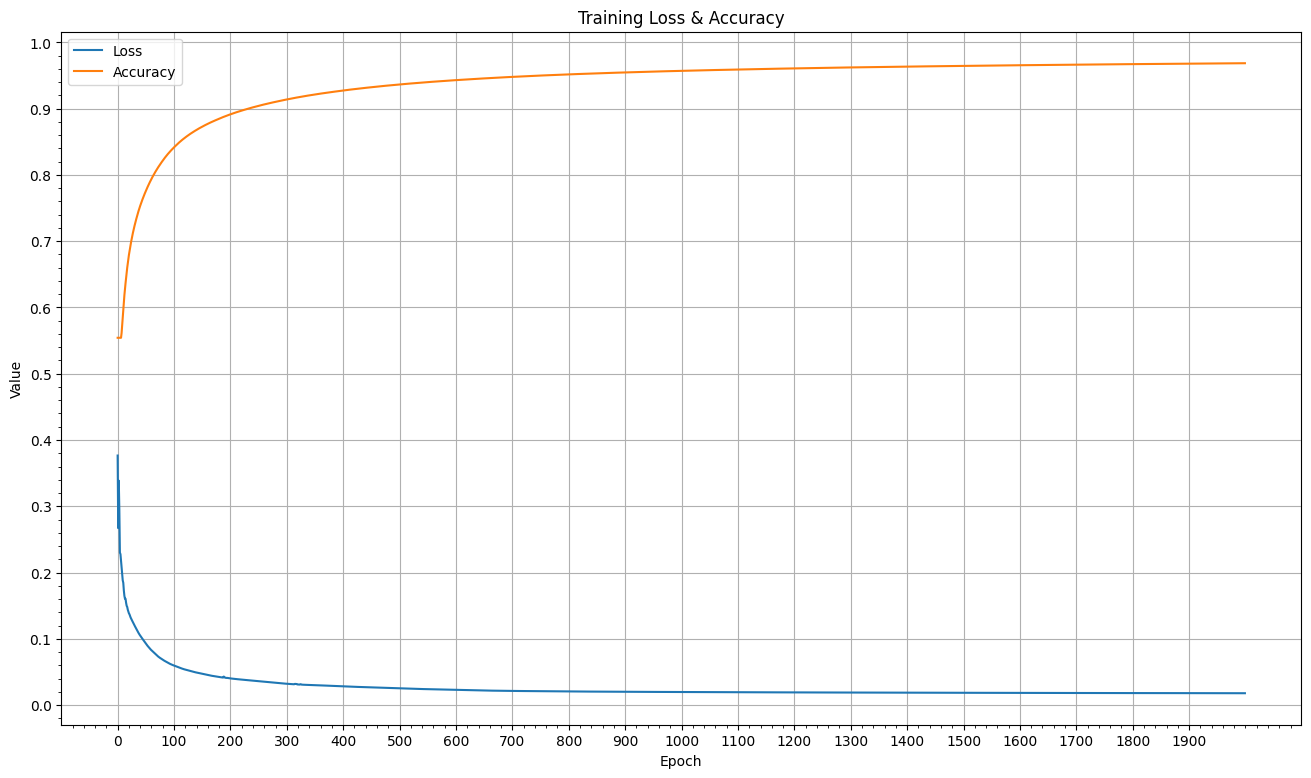

In [7]:
epcs = 2000

trainRes, testAcc = runTrainTest(getRunner(epcs))

print(f'Test accuracy: \033[0;94m{testAcc:.4f}\033[0m')

plotAccLoss(trainRes['losses'], trainRes['accuracies'], epcs)

### Grid Search Optimizeras & Loss Functions w/ K-Fold Cross Validation

[1/30] Running grid search for loss: MSELoss, optimizer: Rprop
Epoch [ 100/1000	], Loss:	0.0618, Acc:	0.8421
Epoch [ 200/1000	], Loss:	0.0449, Acc:	0.8868
Epoch [ 300/1000	], Loss:	0.0377, Acc:	0.9072
Epoch [ 400/1000	], Loss:	0.0342, Acc:	0.9194
Epoch [ 500/1000	], Loss:	0.0320, Acc:	0.9274
Epoch [ 600/1000	], Loss:	0.0307, Acc:	0.9331
Epoch [ 700/1000	], Loss:	0.0297, Acc:	0.9375
Epoch [ 800/1000	], Loss:	0.0290, Acc:	0.9411
Epoch [ 900/1000	], Loss:	0.0285, Acc:	0.9438
Epoch [ 1000/1000	], Loss:	0.0281, Acc:	0.9462
Epoch [ 100/1000	], Loss:	0.0529, Acc:	0.8494
Epoch [ 200/1000	], Loss:	0.0359, Acc:	0.8992
Epoch [ 300/1000	], Loss:	0.0304, Acc:	0.9203
Epoch [ 400/1000	], Loss:	0.0277, Acc:	0.9321
Epoch [ 500/1000	], Loss:	0.0258, Acc:	0.9398
Epoch [ 600/1000	], Loss:	0.0244, Acc:	0.9453
Epoch [ 700/1000	], Loss:	0.0233, Acc:	0.9496
Epoch [ 800/1000	], Loss:	0.0227, Acc:	0.9528
Epoch [ 900/1000	], Loss:	0.0222, Acc:	0.9553
Epoch [ 1000/1000	], Loss:	0.0217, Acc:	0.9573
Epoch [ 100/100

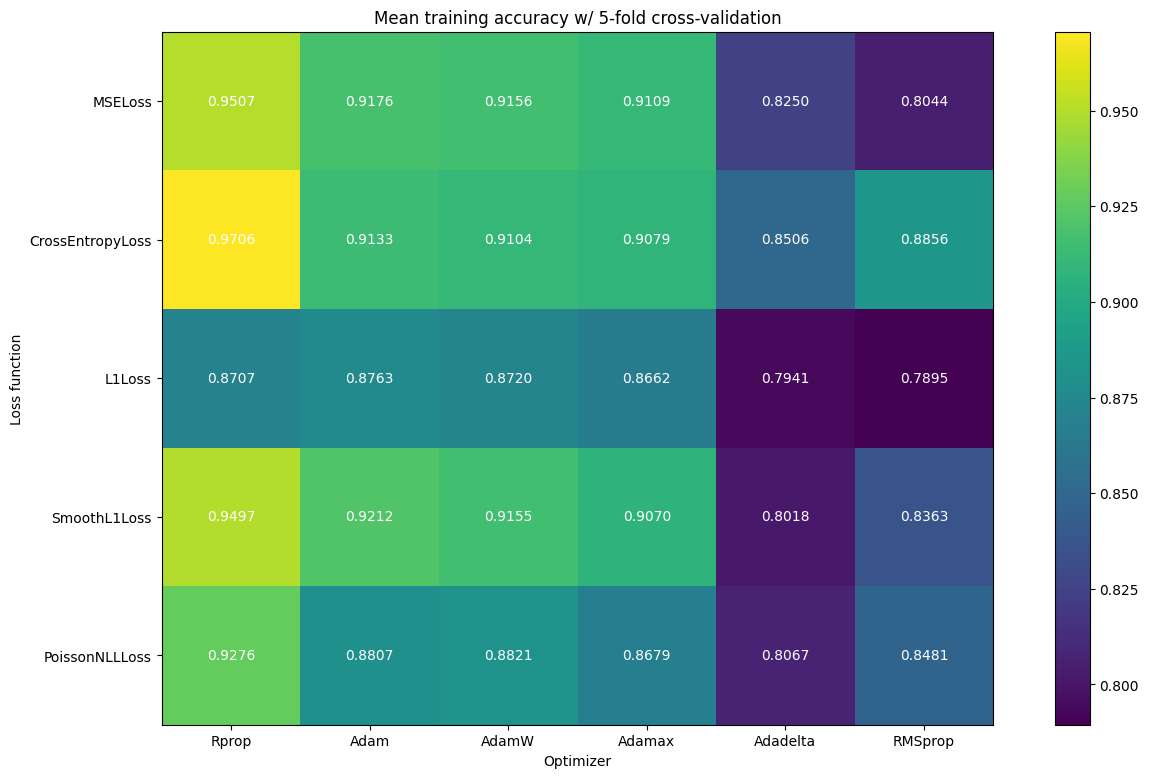

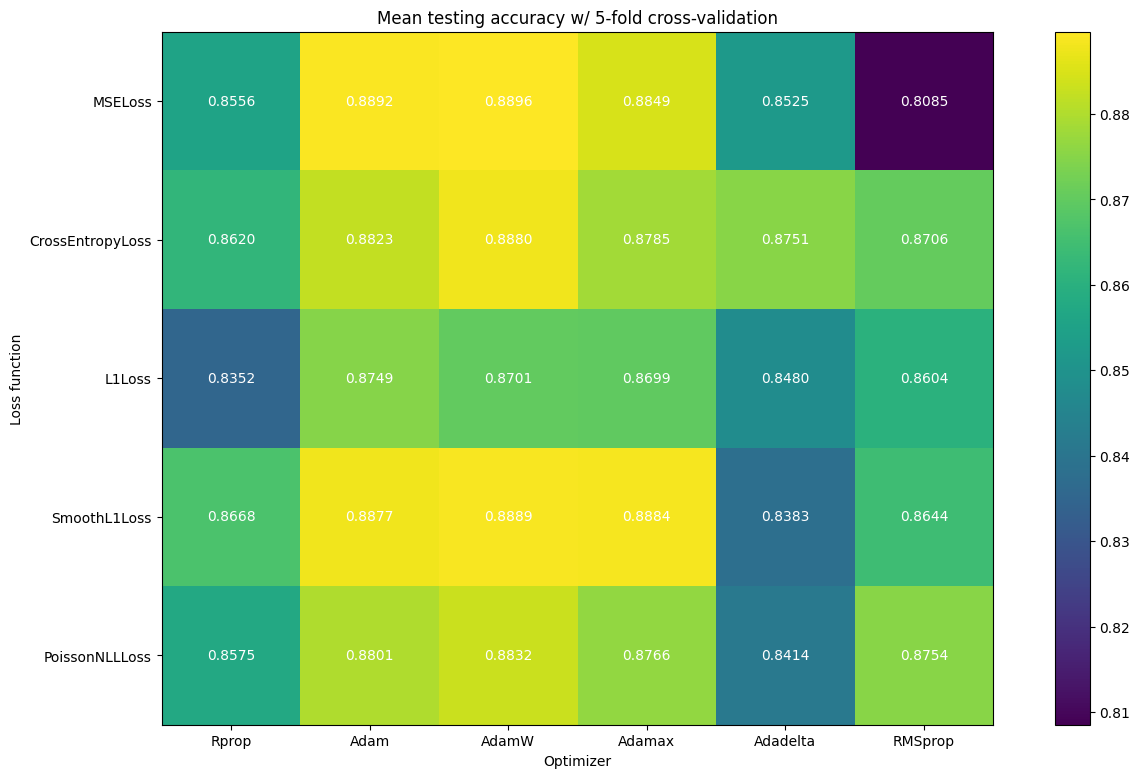

In [14]:
epcs = 1000
k = 5

#----- Run Grid search -----#
lossFuncs = [nn.MSELoss, nn.CrossEntropyLoss, nn.L1Loss, nn.SmoothL1Loss, nn.PoissonNLLLoss]
optimizers = [optim.Rprop, optim.Adam, optim.AdamW, optim.Adamax, optim.Adadelta, optim.RMSprop]

grids = {
    "trainLoss":    { "mean": [], "std": [] },
    "trainAcc":     { "mean": [], "std": [] },
    "testAcc":      { "mean": [], "std": [] },
}

i = 1
totIters = len(lossFuncs) * len(optimizers)
for loss in lossFuncs:
# for lr in learningRates:
    for opt in optimizers:
        print(f"[{i}/{totIters}] Running grid search for loss: {loss.__name__}, optimizer: {opt.__name__}")
        result: List[Tuple[TrainResults, float]] = runKFold(getRunner(epcs, loss, [opt]), k)
        print()

        aggr = aggrKFold(result)
        grids["trainLoss"]["mean"].append(aggr["trainLoss"]["mean"])
        grids["trainAcc"]["mean"].append(aggr["trainAcc"]["mean"])
        grids["testAcc"]["mean"].append(aggr["testAcc"]["mean"])

        grids["trainLoss"]["std"].append(aggr["trainLoss"]["std"])
        grids["trainAcc"]["std"].append(aggr["trainAcc"]["std"])
        grids["testAcc"]["std"].append(aggr["testAcc"]["std"])

        i += 1

#----- Plot as heatmap -----#

plotGrid(
    f"Mean training accuracy w/ {k}-fold cross-validation",
    "Optimizer",
    "Loss function",
    [opt.__name__ for opt in optimizers],
    [loss.__name__ for loss in lossFuncs],
    grids["trainAcc"]["mean"]
)

plotGrid(
    f"Mean testing accuracy w/ {k}-fold cross-validation",
    "Optimizer",
    "Loss function",
    [opt.__name__ for opt in optimizers],
    [loss.__name__ for loss in lossFuncs],
    grids["testAcc"]["mean"]
)

### Grid Search Activation Functions & RProp Learning Rates w/ K-Fold Cross Validation

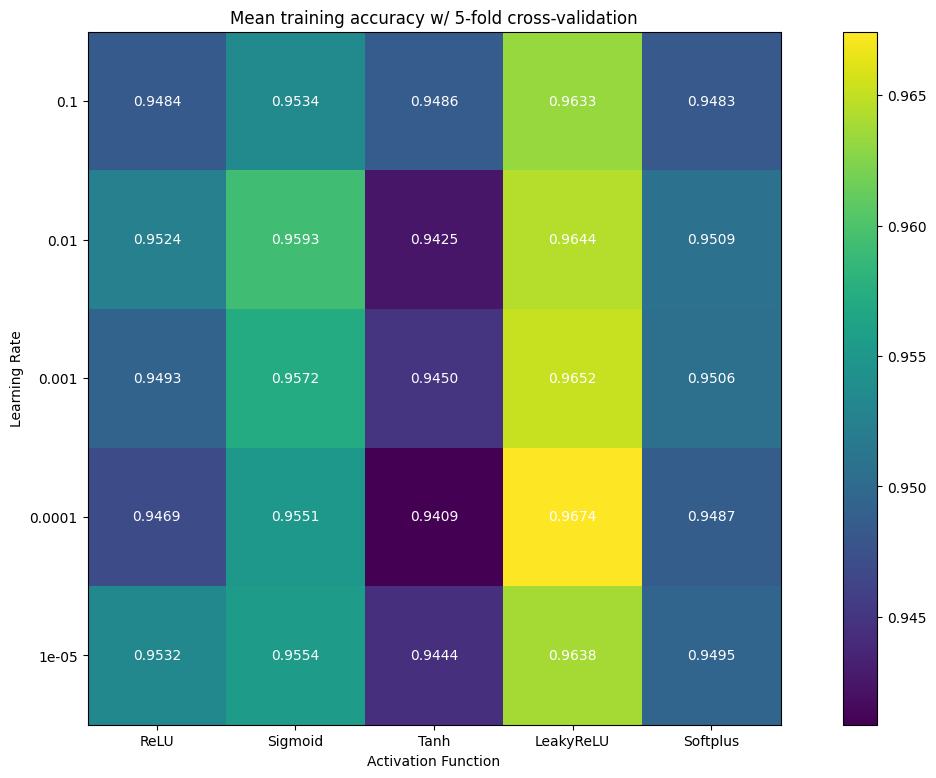

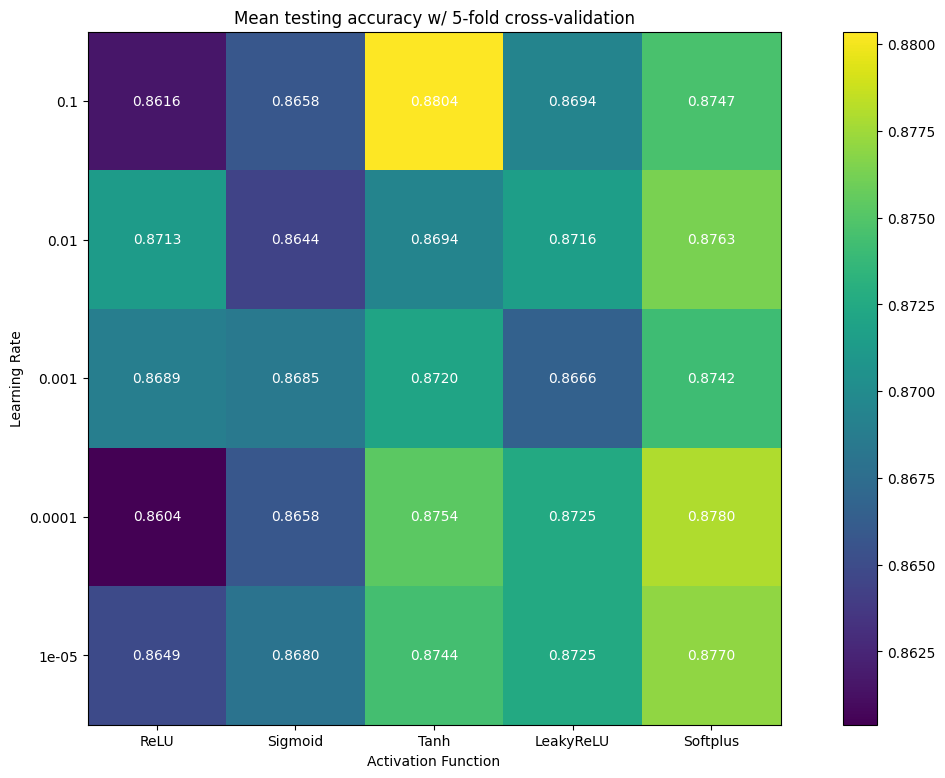

In [22]:
epcs = 1000
k = 5

#----- Run Grid search -----#
activations = [nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU, nn.Softplus]
learningRates = [0.1, 0.01, 0.001, 0.0001, 0.00001]

grids = {
    "trainLoss":    { "mean": [], "std": [] },
    "trainAcc":     { "mean": [], "std": [] },
    "testAcc":      { "mean": [], "std": [] },
}

i = 1
totIters = len(activations) * len(learningRates)
for lr in learningRates:
    for act in activations:
        print(f"[{i}/{totIters}] Running grid search for learning rate: {lr}, activation: {act.__name__}")
        result: List[Tuple[TrainResults, float]] = runKFold(getRunner(epcs, act=act, lr=lr), k)
        print()

        aggr = aggrKFold(result)
        grids["trainLoss"]["mean"].append(aggr["trainLoss"]["mean"])
        grids["trainAcc"]["mean"].append(aggr["trainAcc"]["mean"])
        grids["testAcc"]["mean"].append(aggr["testAcc"]["mean"])

        grids["trainLoss"]["std"].append(aggr["trainLoss"]["std"])
        grids["trainAcc"]["std"].append(aggr["trainAcc"]["std"])
        grids["testAcc"]["std"].append(aggr["testAcc"]["std"])

        i += 1

#----- Plot as heatmap -----#

plotGrid(
    f"Mean training accuracy w/ {k}-fold cross-validation",
    "Activation Function",
    "Learning Rate",
    [act.__name__ for act in activations],
    [str(lr) for lr in learningRates],
    grids["trainAcc"]["mean"]
)

plotGrid(
    f"Mean testing accuracy w/ {k}-fold cross-validation",
    "Activation Function",
    "Learning Rate",
    [act.__name__ for act in activations],
    [str(lr) for lr in learningRates],
    grids["testAcc"]["mean"]
)

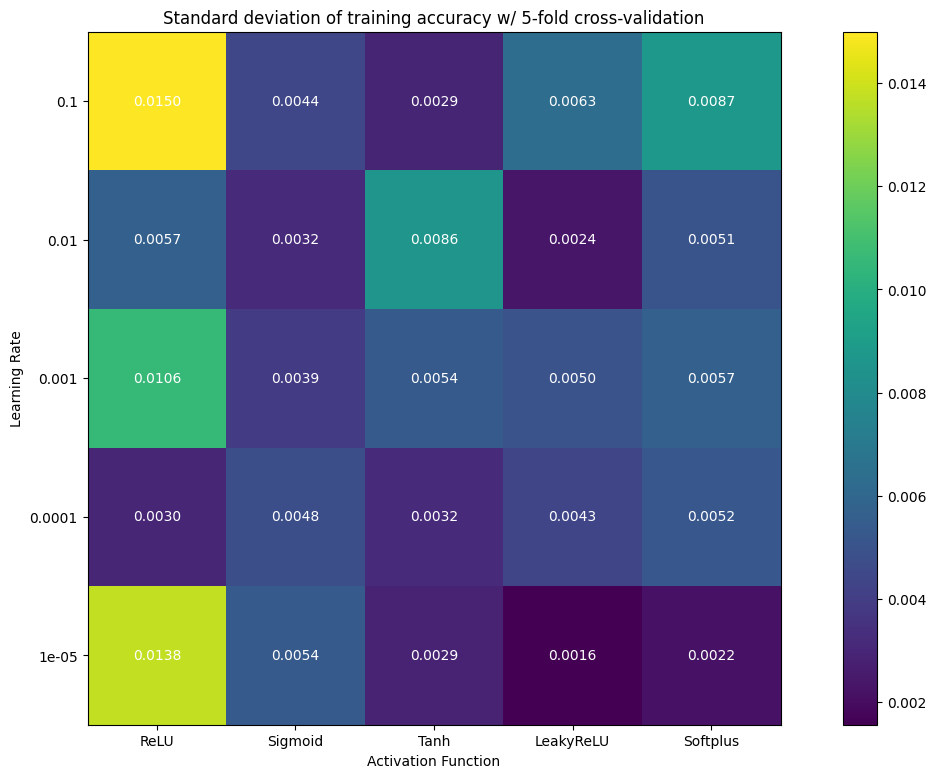

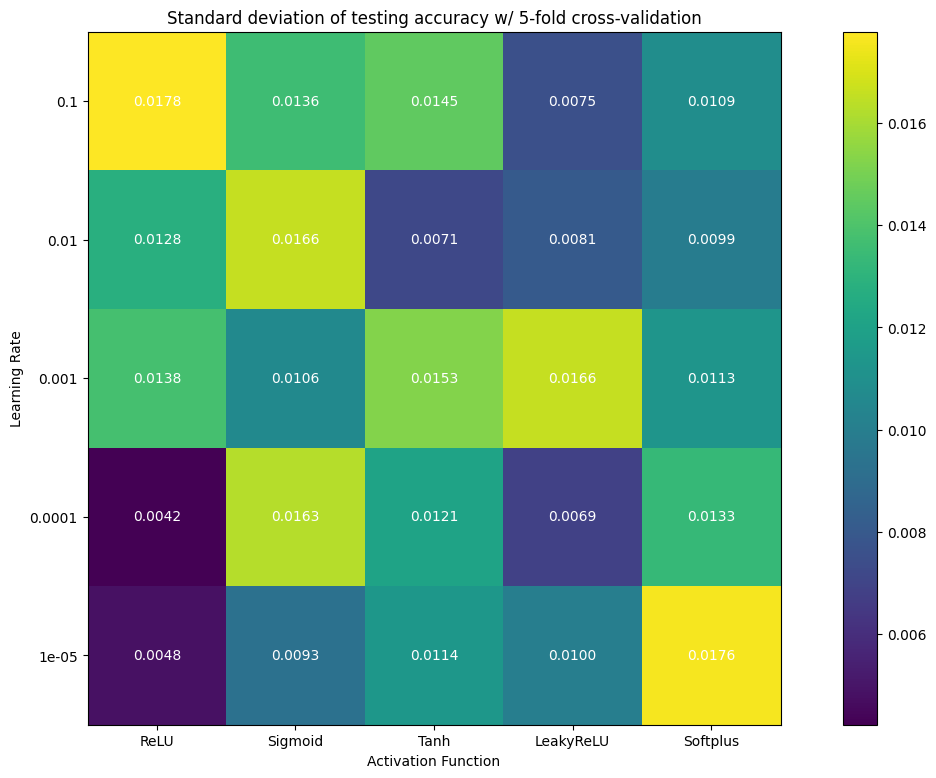

In [21]:
# Standard deviation plots
plotGrid(
    f"Standard deviation of training accuracy w/ {k}-fold cross-validation",
    "Activation Function",
    "Learning Rate",
    [act.__name__ for act in activations],
    [str(lr) for lr in learningRates],
    grids["trainAcc"]["std"]
)

plotGrid(
    f"Standard deviation of testing accuracy w/ {k}-fold cross-validation",
    "Activation Function",
    "Learning Rate",
    [act.__name__ for act in activations],
    [str(lr) for lr in learningRates],
    grids["testAcc"]["std"]
)

### Comparing optimizers

[1/8] Running comparison for optimizer: [Rprop&Adam&AdamW]
Epoch [ 100/1000	], Loss:	0.0601, Acc:	0.8421
Epoch [ 200/1000	], Loss:	0.0390, Acc:	0.8920
Epoch [ 300/1000	], Loss:	0.0310, Acc:	0.9148
Epoch [ 400/1000	], Loss:	0.0249, Acc:	0.9289
Epoch [ 500/1000	], Loss:	0.0195, Acc:	0.9389
Epoch [ 600/1000	], Loss:	0.0167, Acc:	0.9464
Epoch [ 700/1000	], Loss:	0.0157, Acc:	0.9523
Epoch [ 800/1000	], Loss:	0.0128, Acc:	0.9569
Epoch [ 900/1000	], Loss:	0.0139, Acc:	0.9606
Epoch [ 1000/1000	], Loss:	0.0122, Acc:	0.9637
Epoch [ 100/1000	], Loss:	0.0715, Acc:	0.8269
Epoch [ 200/1000	], Loss:	0.0532, Acc:	0.8758
Epoch [ 300/1000	], Loss:	0.0457, Acc:	0.8974
Epoch [ 400/1000	], Loss:	0.0380, Acc:	0.9103
Epoch [ 500/1000	], Loss:	0.0323, Acc:	0.9193
Epoch [ 600/1000	], Loss:	0.0308, Acc:	0.9260
Epoch [ 700/1000	], Loss:	0.0311, Acc:	0.9316
Epoch [ 800/1000	], Loss:	0.0234, Acc:	0.9362
Epoch [ 900/1000	], Loss:	0.0245, Acc:	0.9400
Epoch [ 1000/1000	], Loss:	0.0202, Acc:	0.9435
Epoch [ 100/1000	],

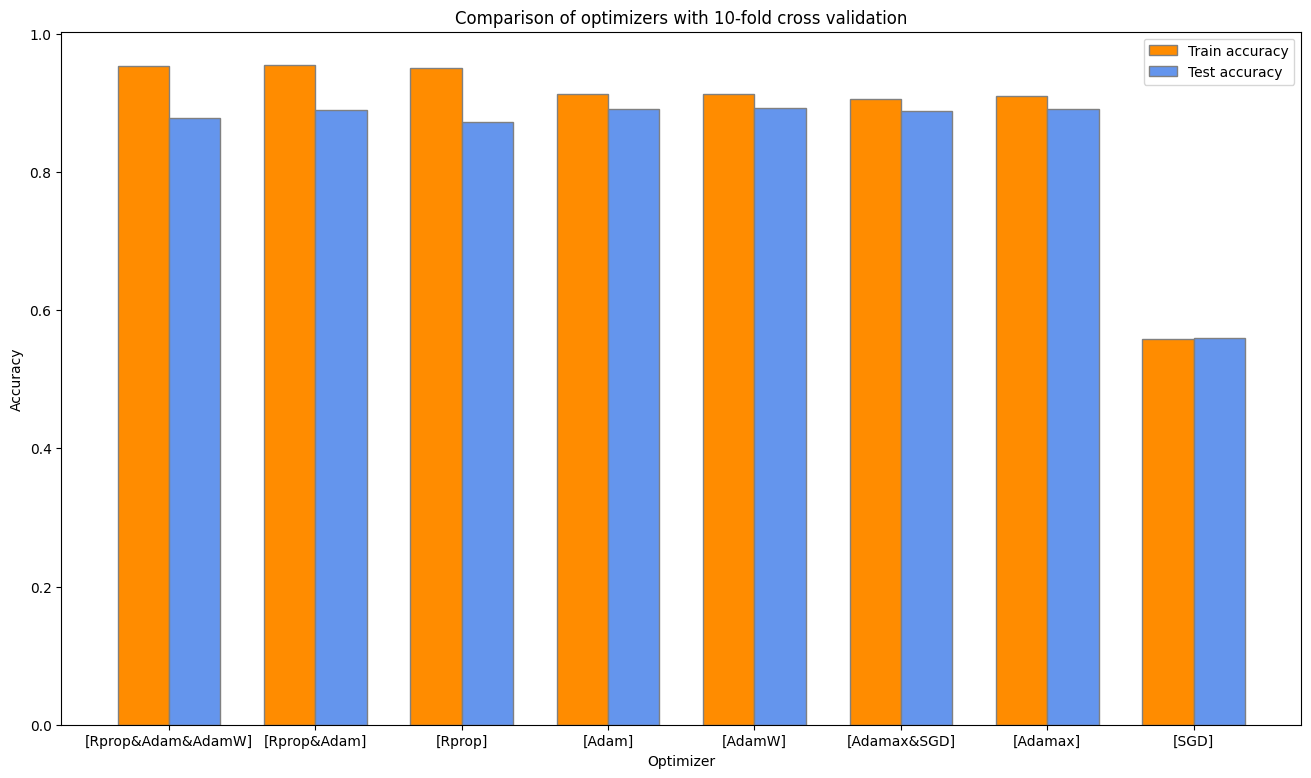

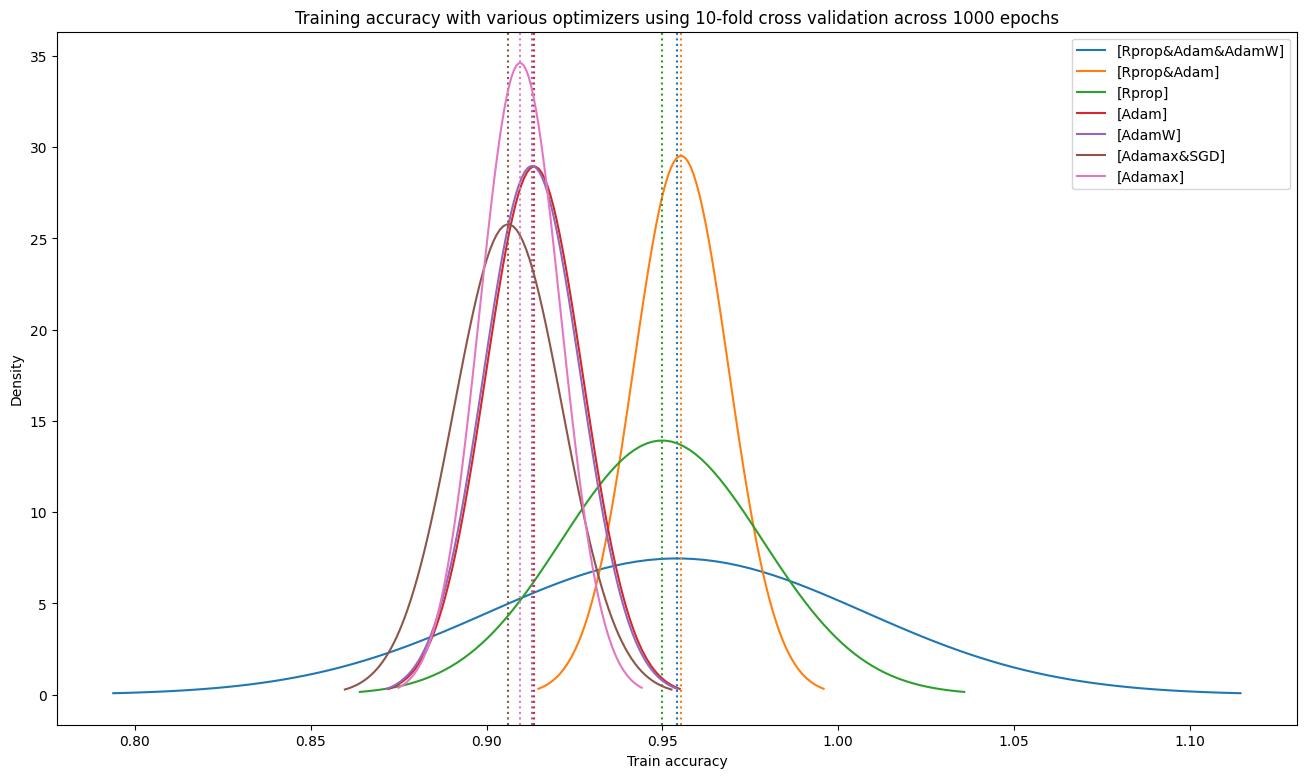

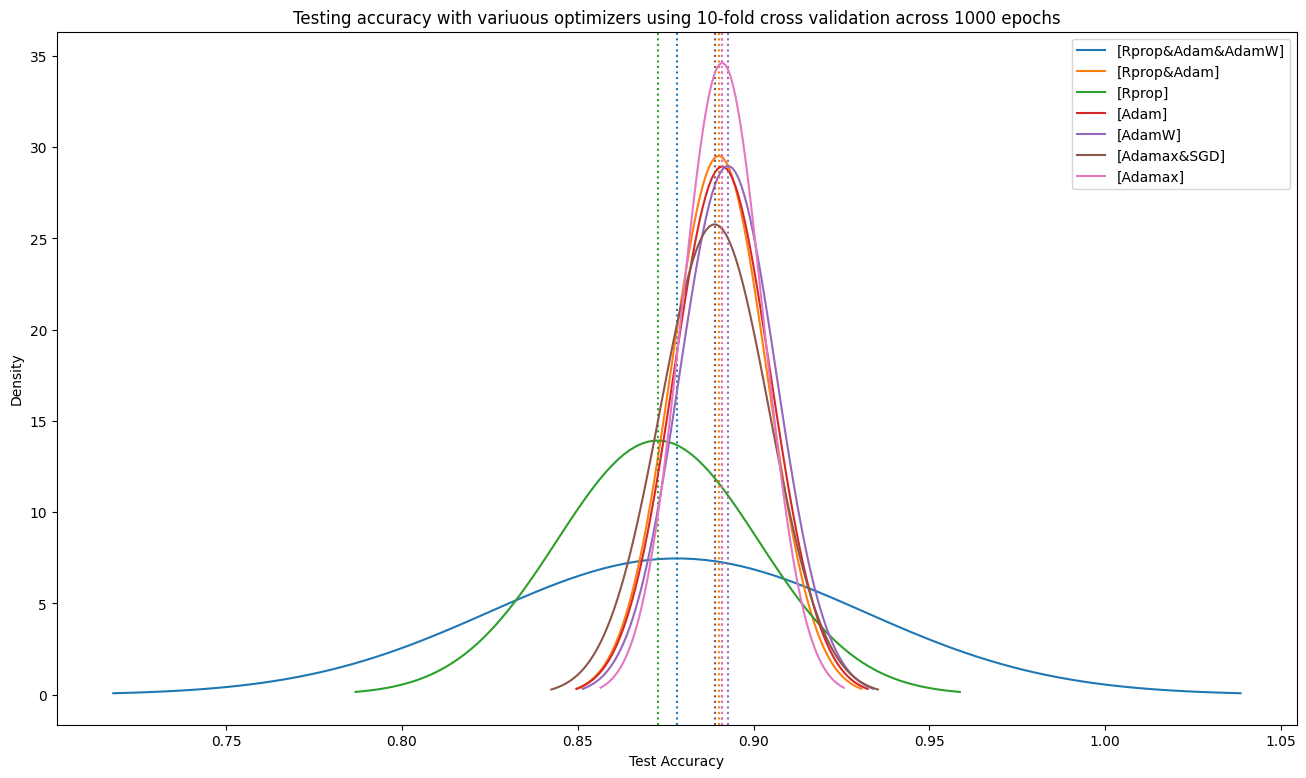

In [ ]:
k = 10
epcs = 1000

compOpts = [[optim.Rprop, optim.Adam, optim.AdamW], [optim.Rprop, optim.Adam], [optim.Rprop], [optim.Adam], [optim.AdamW], [optim.Adamax, optim.SGD], [optim.Adamax], [optim.SGD]]

trainAccs = []
trainAccStds = []
testAccs = []
testAccStds = []

i = 1
for opts in compOpts:
    print(f"[{i}/{len(compOpts)}] Running comparison for optimizer: {compToName(opts)}")
    result: List[Tuple[TrainResults, float]] = runKFold(getRunner(epcs, opts=opts), k)
    aggr = aggrKFold(result)

    trainAccs.append(aggr["trainAcc"]["mean"])
    trainAccStds.append(aggr["trainAcc"]["std"])
    testAccs.append(aggr["testAcc"]["mean"])
    testAccStds.append(aggr["testAcc"]["std"])

    print(f'Test accuracy: \033[0;94m{aggr["testAcc"]["mean"]:.4f}\033[0m')

    print()
    i += 1

plotOptBar(compOpts, trainAccs, testAccs, f"Comparison of optimizers with {k}-fold cross validation")

plotBell(compOpts, trainAccs, testAccStds, f"Training accuracy with various optimizers using {k}-fold cross validation across {epcs} epochs", "Train accuracy")
plotBell(compOpts, testAccs, testAccStds, f"Testing accuracy with variuous optimizers using {k}-fold cross validation across {epcs} epochs", "Test Accuracy")

### Final Hybrid Optimization Model

In [35]:
import itertools

epcs = 500
k = 5

unitOpts = [optim.Rprop, optim.Adam, optim.AdamW, optim.Adamax]

# Generate a list of all possible combinations of optimizers
compOpts = []
for i in range(1, len(unitOpts)+1):
    compOpts.extend(list(itertools.combinations(unitOpts, i)))

# Run all combinations and find best
results = []
bestAcc = 0
bestAccIdx = 0
i = 1
for opts in compOpts:
    print(f"[{i}/{len(compOpts)}] Running w/ optimizer: {compToName(opts)}")
    # Use optimal params as found in grid search above
    result: List[Tuple[TrainResults, float]] = runKFold(getRunner(epcs, loss=nn.MSELoss, opts=opts, act=nn.LeakyReLU), k)
    aggr = aggrKFold(result)

    results.append(result)

    print(f'Test accuracy: \033[0;94m{aggr["testAcc"]["mean"]:.4f}\033[0m')

    if (aggr["testAcc"]["mean"] > bestAcc):
        print(f'\033[0;92mNew best combination found\033[0m')
        bestAcc = aggr["testAcc"]["mean"]
        bestAccIdx = i-1
    
    i += 1
    print()

print(f'--> \033[0;92mBest accuracy found\033[0m: \033[0;94m{bestAcc:.4f}\033[0m with combination: {compToName(compOpts[bestAccIdx])}')

[1/15] Running w/ optimizer: [Rprop]
Epoch [ 100/500	], Loss:	0.0545, Acc:	0.8552
Epoch [ 200/500	], Loss:	0.0324, Acc:	0.9027
Epoch [ 300/500	], Loss:	0.0236, Acc:	0.9255
Epoch [ 400/500	], Loss:	0.0195, Acc:	0.9388
Epoch [ 500/500	], Loss:	0.0172, Acc:	0.9476
Epoch [ 100/500	], Loss:	0.0603, Acc:	0.8487
Epoch [ 200/500	], Loss:	0.0441, Acc:	0.8918
Epoch [ 300/500	], Loss:	0.0370, Acc:	0.9117
Epoch [ 400/500	], Loss:	0.0322, Acc:	0.9236
Epoch [ 500/500	], Loss:	0.0286, Acc:	0.9318
Epoch [ 100/500	], Loss:	0.0565, Acc:	0.8444
Epoch [ 200/500	], Loss:	0.0346, Acc:	0.8984
Epoch [ 300/500	], Loss:	0.0271, Acc:	0.9217
Epoch [ 400/500	], Loss:	0.0222, Acc:	0.9347
Epoch [ 500/500	], Loss:	0.0196, Acc:	0.9432
Epoch [ 100/500	], Loss:	0.0467, Acc:	0.8576
Epoch [ 200/500	], Loss:	0.0236, Acc:	0.9118
Epoch [ 300/500	], Loss:	0.0166, Acc:	0.9347
Epoch [ 400/500	], Loss:	0.0132, Acc:	0.9477
Epoch [ 500/500	], Loss:	0.0115, Acc:	0.9561
Epoch [ 100/500	], Loss:	0.0537, Acc:	0.8434
Epoch [ 200/500	],

### Hybrid model results

In [52]:
# Tabulate results
for i, (opts, result) in enumerate(zip(compOpts, results)):
    aggr = aggrKFold(result)
    print(f"[{i+1}]:{' ' if i<9 else ''} {compToName(opts)}{' ' * (26-len(compToName(opts)))}{aggr['testAcc']['mean']:.4f} ± {aggr['testAcc']['std']:.4f}{' (best)' if i == bestAccIdx else ''}")

[1]:  [Rprop]                   0.8673 ± 0.0125
[2]:  [Adam]                    0.8844 ± 0.0155
[3]:  [AdamW]                   0.8882 ± 0.0105
[4]:  [Adamax]                  0.8851 ± 0.0115
[5]:  [Rprop&Adam]              0.8818 ± 0.0109
[6]:  [Rprop&AdamW]             0.8875 ± 0.0153
[7]:  [Rprop&Adamax]            0.8785 ± 0.0149
[8]:  [Adam&AdamW]              0.8820 ± 0.0109
[9]:  [Adam&Adamax]             0.8835 ± 0.0127
[10]: [AdamW&Adamax]            0.8839 ± 0.0130
[11]: [Rprop&Adam&AdamW]        0.8901 ± 0.0110
[12]: [Rprop&Adam&Adamax]       0.8913 ± 0.0117
[13]: [Rprop&AdamW&Adamax]      0.8861 ± 0.0144
[14]: [Adam&AdamW&Adamax]       0.8975 ± 0.0146 (best)
[15]: [Rprop&Adam&AdamW&Adamax] 0.8806 ± 0.0092


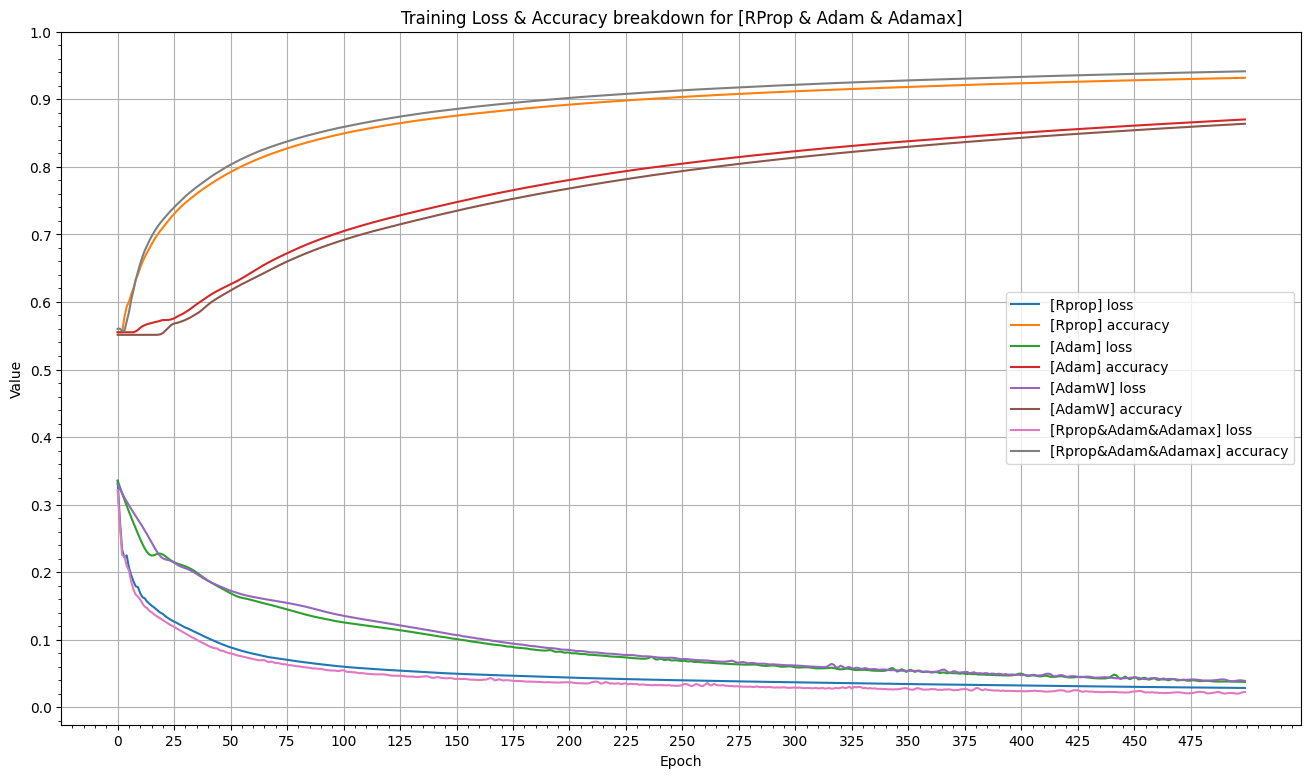

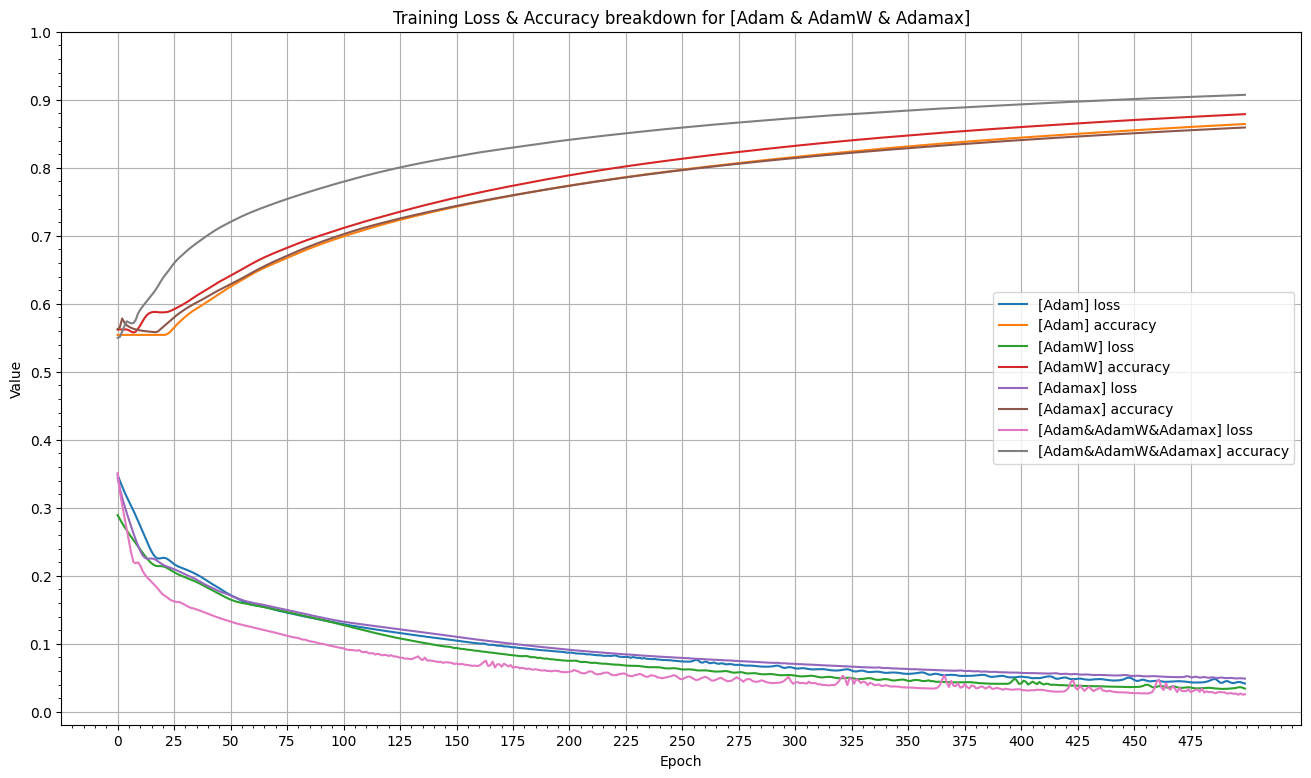

In [102]:
# Plot [RProp], [Adam], [Adamax], and [RProp & Adam & Adamax] training accuracies
toGraph = [0, 1, 2, 11]
labels = [compToName(compOpts[i]) for i in toGraph]
losses = [results[i][1][0]["losses"] for i in toGraph]
accuracies = [results[i][1][0]["accuracies"] for i in toGraph]

plotMultiAccLoss(losses, accuracies, labels, epcs, "Training Loss & Accuracy breakdown for [RProp & Adam & Adamax]")


# Plot [Adam], [AdamW], [Adamax], and [Adam & AdamW & Adamax] training accuracies
toGraph = [1, 2, 3, 13]
labels = [compToName(compOpts[i]) for i in toGraph]
losses = [results[i][0][0]["losses"] for i in toGraph]
accuracies = [results[i][0][0]["accuracies"] for i in toGraph]

plotMultiAccLoss(losses, accuracies, labels, epcs, "Training Loss & Accuracy breakdown for [Adam & AdamW & Adamax]")